Das Ziel ist es mit diversen Klassifikations-Modelle vorherzusagen, ob die Heimmannschaft gewinnt oder nicht. Wir werden den endgültigen Datensatz verwenden, den wir durch unser früheres "Scraping and Cleaning"-Notebook erhalten haben, auf dem wir unser Vorhersagemodell aufbauen.

In [34]:
# die nötigen Libraries importieren

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display

In [35]:
# einlesen von Daten und die redundanten Spalten rausnehmen
data = pd.read_csv("C:/Users/kevin/Dropbox/Vorlesungen/Applied Data Science/Projekt/Daten/final_dataset.csv")

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)


# Vorschau der Daten
display(data)

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3
0,1,0,0,M,M,M,M,M,M
1,0,0,0,M,M,M,M,M,M
2,0,0,0,M,M,M,M,M,M
3,0,0,0,M,M,M,M,M,M
4,1,0,0,M,M,M,M,M,M
...,...,...,...,...,...,...,...,...,...
1895,1,45,58,L,D,W,L,W,D
1896,1,49,40,D,W,W,L,L,L
1897,1,89,51,W,W,D,D,L,D
1898,1,90,45,D,W,W,D,D,L


## Datenerhebung

In [36]:
# Gesamtzahl der Spiele
matches = data.shape[0]

# Berechung der Anzahl der Merkmale
features = data.shape[1] - 1

# Berechnung der von der Heimmanschaft gewonnenen Spiele
homewins = len(data[data.FTR == 1])

# Berechnung der Gewinnrate des Heimteams
win_rate = (float(homewins) / (matches)) * 100

# Resultate ausgeben
print ("Gesamtzahl der Spiele: {}".format(matches))
print ("Anzahl der Features: {}".format(features))
print ("Anzahl der von der Heimmanschaft gewonnenen Spiele: {}".format(homewins))
print ("Gewinnrate der Heimmanschaft: {:.2f}%".format(win_rate))

Gesamtzahl der Spiele: 1900
Anzahl der Features: 8
Anzahl der von der Heimmanschaft gewonnenen Spiele: 833
Gewinnrate der Heimmanschaft: 43.84%


## Aufbereitung der Daten

In [37]:
# Aufteilung in Feature-Set und Targetvariable
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardissierung der Daten
from sklearn.preprocessing import scale


cols = [['HTP','ATP']] 
for col in cols:
    X_all[col] = scale(X_all[col])


In [38]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    ''' Verarbeitet die Fussballdaten vor und konvertiert katagorische Variablen in Dummy-Variablen. '''
    
    # Neuen Ausgabe-DataFrame initialisieren
    output = pd.DataFrame(index = X.index)

    # jede Merkmalsspalte für die Daten untersuchen
    for col, col_data in X.iteritems():

        # Wenn der Datentyp kategorisch ist, in Dummy-Variablen umwandeln
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # die überarbeiteten Spalten sammeln
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Verarbeitete Feature-Spalten (Total {} Features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Verarbeitete Feature-Spalten (Total 26 Features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W']


In [39]:
# Ausgabe der fünf ersten Zeilen mit den Feature Infos
print ("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_M,HM1_W,HM2_D,HM2_L,HM2_M,HM2_W,...,AM1_M,AM1_W,AM2_D,AM2_L,AM2_M,AM2_W,AM3_D,AM3_L,AM3_M,AM3_W
0,-1.362444,-1.366811,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,-1.362444,-1.366811,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,-1.362444,-1.366811,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
3,-1.362444,-1.366811,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
4,-1.362444,-1.366811,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [40]:
from sklearn.model_selection import train_test_split

# Mischen und Aufteilen des Datensatzes in einen Trainings- und einen Testsatz
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)


## Training und Auswertung von Modellen

In [41]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Passt einen Klassifikator an die Trainingsdaten an. '''
    
    # Den Timer beim starten und nach dem Training stopen
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Ausgabe der Resultate
    print ("Modell wurde in {:.4f} Sekunden trainiert".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Erstellt Vorhersagen mithilfe eines geeigneten Klassifizierers auf der Grundlage der F1-Score. '''
    
    # Den Timer starten und nach der Vorhersage stopen
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Ausgabe der Resultate
    print ("Vorhersage wurde in {:.4f} Sekunden generiert.".format(end - start))
    
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Trainieren und Vorhersagen mit einem Klassifikator auf der Grundlage der F1-Score. '''
    
    # den Klassifikator und die Grösse der Trainingsmenge angeben
    print ("Training einer {} mit einer Trainingsmenge von {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # den Klassifikator trainieren
    train_classifier(clf, X_train, y_train)
    
    # Ausgabe Ergebnisse der Vorhersage für Training und Test
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1-Score und Accuracy-Score für Training-Set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1-Score und Accuracy-Score für Test-Set: {:.4f} , {:.4f}.".format(f1 , acc))

In [42]:
# Initialisierung der zwei Modelle (XGBoost wird später initialisiert)
clf_SVC = SVC(random_state = 912, kernel='rbf')
clf_xgbClass = xgb.XGBClassifier(seed = 82)

train_predict(clf_SVC, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_xgbClass, X_train, y_train, X_test, y_test)
print ('')

Training einer SVC mit einer Trainingsmenge von 1850. . .
Modell wurde in 0.4855 Sekunden trainiert
Vorhersage wurde in 0.7354 Sekunden generiert.
0.6217765042979942 0.7145945945945946
F1-Score und Accuracy-Score für Training-Set: 0.6218 , 0.7146.
Vorhersage wurde in 0.0255 Sekunden generiert.
F1-Score und Accuracy-Score für Test-Set: 0.5000 , 0.6400.

Training einer XGBClassifier mit einer Trainingsmenge von 1850. . .
[14:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modell wurde in 0.6204 Sekunden trainiert
Vorhersage wurde in 0.0202 Sekunden generiert.
0.945179584120983 0.952972972972973
F1-Score und Accuracy-Score für Training-Set: 0.9452 , 0.9530.
Vorhersage wurde in 0.0172 Sekunden generiert.
F1-Score und Accuracy-Score für Test-Set: 0.5714 , 0.6400.



## Abstimmung der Parameter von XGBoost

In [43]:
# 'GridSearchCV' und 'make_scorer' importieren
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Parameter abstimmen
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# Initialisierung des Klassifikators
clf = xgb.XGBClassifier(seed=2)

# F1-Score Bewertungsfunktion mit "make_scorer"
f1_scorer = make_scorer(f1_score,pos_label=1)

# Durchführung einer Rastersuche für den Klassifikator unter Verwendung des f1_scorer als Bewertungsmethode
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# Anpassung des Rastersuchobjekts an die Trainingsdaten und Ermittlung der optimalen Parameter
grid_obj = grid_obj.fit(X_train,y_train)

# den Estimator holen
clf = grid_obj.best_estimator_
print (clf)

# endgültige F1-Scorer für Training und Test nach der Parameterabstimmung ausgeben
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1-Score und Accuracy-Score für Training-Set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1-Score und Accuracy-Score für Test-Set: {:.4f} , {:.4f}.".format(f1 , acc))

[14:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[14:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=2, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
              seed=2, subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)
Vorhersage wurde in 0.0193 Sekunden generiert.
F1-Score und Accuracy-Score für Training-Set: 0.5919 , 0.6914.
Vorhersage wurde in 0.0120 Sekunden generiert.
F1-Score und Accuracy-Score für Test-Set: 0.4444 , 0.6000.


## Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[24  4]
 [12 10]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        28
           1       0.71      0.45      0.56        22

    accuracy                           0.68        50
   macro avg       0.69      0.66      0.65        50
weighted avg       0.69      0.68      0.66        50



[Text(252.43751194571865, 212.26285714285714, 'X[0] <= 1.07\ngini = 0.492\nsamples = 1900\nvalue = [1067, 833]'),
 Text(185.92815844801223, 201.90857142857143, 'X[1] <= 0.313\ngini = 0.481\nsamples = 1628\nvalue = [973, 655]'),
 Text(123.72359518348624, 191.5542857142857, 'X[5] <= 0.5\ngini = 0.495\nsamples = 1189\nvalue = [656, 533]'),
 Text(69.7470374617737, 181.2, 'X[23] <= 0.5\ngini = 0.478\nsamples = 779\nvalue = [472, 307]'),
 Text(38.47507645259939, 170.84571428571428, 'X[1] <= -0.54\ngini = 0.454\nsamples = 503\nvalue = [328, 175]'),
 Text(23.652905198776757, 160.49142857142857, 'X[0] <= -0.534\ngini = 0.48\nsamples = 280\nvalue = [168, 112]'),
 Text(10.295412844036697, 150.13714285714286, 'X[1] <= -1.34\ngini = 0.471\nsamples = 253\nvalue = [157, 96]'),
 Text(3.943730886850153, 139.78285714285715, 'X[0] <= -1.229\ngini = 0.5\nsamples = 65\nvalue = [33, 32]'),
 Text(3.3370030581039756, 129.42857142857144, 'X[2] <= 0.5\ngini = 0.5\nsamples = 63\nvalue = [31, 32]'),
 Text(2.73027

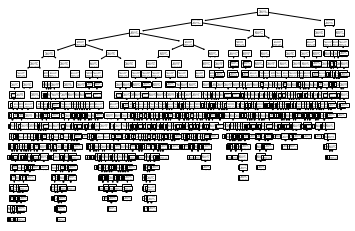

In [45]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit (X_all,y_all)

tree.plot_tree(clf)

## Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [47]:
# Vorhersagemethode des Random Forest auf die Testdaten anwenden
predictions = rf.predict(X_test)

# die absoluten Fehler berechnen
errors = abs(predictions - y_test)

# Ausgabe Mean Absolute Error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.44 degrees.


In [48]:
# Mean Absolute Percentage Error (MAPE) berechnen
mape = 100 * (errors / y_test)

# Accuracy berechnen und anzeigen
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


## Anpassung des Modells an den gesamten Datensatz für zukünftige Vorhersagen

In [49]:
# 'GridSearchCV' und 'make_scorer' importieren
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Pramater tunen
parameters = { 'learning_rate' : [0.03],
               'n_estimators' : [20],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.2],
               'subsample':[0.8],
               'colsample_bytree':[0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-2]
             }  

# Initialisierung des Klassifikators
clf = xgb.XGBClassifier(seed=2)

# F1-Score Bewertungsfunktion mit "make_scorer" 
f1_scorer = make_scorer(f1_score,pos_label=1)

# Anpassung des Rastersuchobjekts an die Trainingsdaten und Ermittlung der optimalen Parameter
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# Anpassung des Rastersuchobjekts an die Trainingsdaten und Ermittlung der optimalen Parameter
grid_obj = grid_obj.fit(X_all,y_all)

# den Estimator holen
clf = grid_obj.best_estimator_
print (clf)

# endgültige F1-Score für Training nach der Parameterabstimmung ausgeben
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1-Score und Accuracy-Score für Training-Set: {:.4f} , {:.4f}.".format(f1 , acc))

C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constrai